<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Define-transforms-and-model" data-toc-modified-id="Define-transforms-and-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define transforms and model</a></span></li><li><span><a href="#Train!" data-toc-modified-id="Train!-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train!</a></span></li><li><span><a href="#Visualize-results" data-toc-modified-id="Visualize-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualize results</a></span></li></ul></div>

## Load Data

In [1]:
from mantisshrimp.all import *
import pandas as pd

In [2]:
source = Path('/home/lgvaz/.data/wheat')

In [3]:
df = pd.read_csv(source/'train.csv')
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
class WheatInfoParser(ImageParser):
    def __iter__(self): yield from df.itertuples()
    def iid(self, o): return int(o.image_id, 16)
    def file_path(self, o): return self.source/f'train/{o.image_id}.jpg'
    def height(self, o): return o.height
    def width(self, o): return o.width

In [5]:
class WheatAnnotationParser(AnnotationParser):
    def __iter__(self): yield from df.itertuples()
    def iid(self, o): return int(o.image_id, 16)
    def oid(self, o): return 0
    def bbox(self, o): return BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=','))

In [6]:
catmap = CategoryMap([Category(0, 'wheat')])

In [7]:
parser = DataParser(df, source, catmap=catmap, img_parser=WheatInfoParser, annot_parser=WheatAnnotationParser)

In [8]:
rtrain,rvalid = parser.parse()


Removed 0 images that don't have annotations


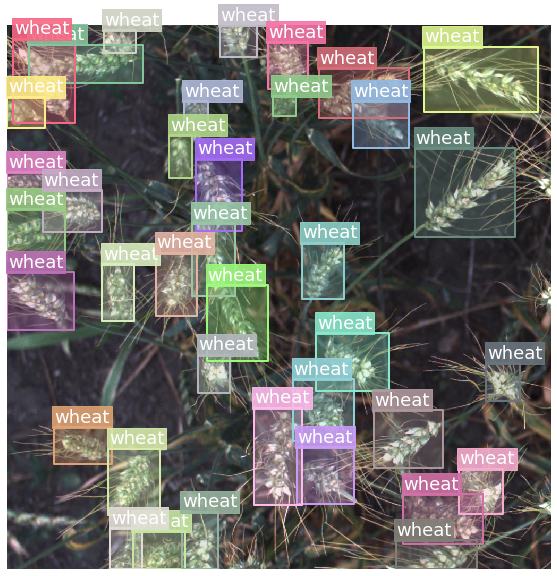

In [9]:
show_record(rtrain[6], catmap=catmap)

## Define transforms and model 

In [10]:
tfms = AlbumentationTransformer([A.Flip()])

In [11]:
train_ds = Dataset(rtrain, tfms=tfms)
train_dl = RCNNDataloader(train_ds, batch_size=4, num_workers=8)

In [12]:
valid_ds = Dataset(rvalid)
valid_dl = RCNNDataloader(valid_ds, batch_size=4, num_workers=8)

In [13]:
metrics = [COCOMetric(rvalid, catmap)]


creating index...
index created!


In [14]:
model = FastRCNNModel(2, metrics=metrics)

## Train!

In [15]:
trainer = Trainer(max_epochs=1, gpus=1, log_gpu_memory=True)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model, train_dl, valid_dl)

INFO:lightning:
    | Name                                  | Type                     | Params
-------------------------------------------------------------------------------
0   | m                                     | FasterRCNN               | 41 M  
1   | m.transform                           | GeneralizedRCNNTransform | 0     
2   | m.backbone                            | BackboneWithFPN          | 26 M  
3   | m.backbone.body                       | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                 | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                   | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                  | ReLU                     | 0     
7   | m.backbone.body.maxpool               | MaxPool2d                | 0     
8   | m.backbone.body.layer1                | Sequential               | 212 K 
9   | m.backbone.body.layer1.0              | Bottleneck               | 73 K  
10  | m.backbone.body.la

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

## Visualize results

In [9]:
model = FastRCNNModel.load_from_checkpoint(checkpoint_path='lightning_logs/version_17/checkpoints/epoch=1.ckpt', n_class=2)

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


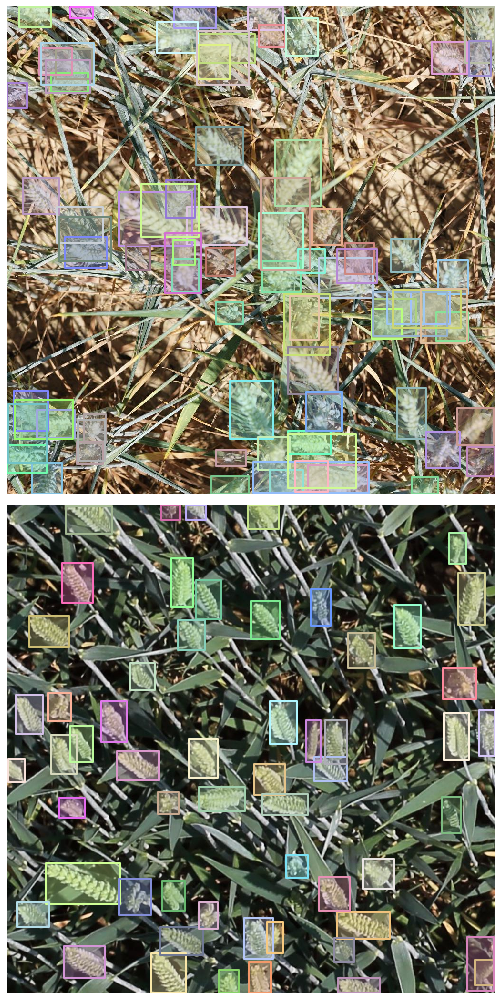

In [16]:
rs = random.choices(rvalid, k=2)
ims,preds = model.predict(rs=rs)
show_preds(ims, preds)

In [1]:
(50*50*512,2)

(1280000, 2)

In [ ]:
Conv2d(512, 2, ks=3x3, pad=1) -> (50, 50, 2)